In [1]:
import sys
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# There are two data files for this exercise
# you may need to change these depending on the location of the data sets
airports_file =  'data/airports-0.xlsx'
flights_file =  'data/flights-1.xlsx'
df_airports = pd.read_excel(airports_file)
df_flights = pd.read_excel(flights_file)

In [3]:
# Create the Graph
G = nx.Graph()

In [4]:
# get the series from the airports file that we need to build the network nodes
codes = df_airports['IATA']
countries = df_airports['Country']
cities = df_airports['City']
lats = df_airports['Latitude']
longs = df_airports['Longitude']

# set the index to the airport code in place
df_airports.set_index('IATA', inplace=True)

# set the index to the flight identifier
df_flights.set_index('FlightId', inplace=True)

# build a dictionary of airport codes for airport data
airport_dict = {} 

# build a dictionary of distances
distance_dict = {}

In [5]:
# Filter out invalid data
for i in range(0,len(codes)): 

    # filter out invalid data - (note this error checking could be more complete)
    if codes[i] == '\\N': continue
    if pd.isnull(codes[i]): continue
    if pd.isnull(cities[i]): continue

    # put the airport in the dictionaries 
    airport_dict[codes[i]] = {} 
    distance_dict[codes[i]] = {}

In [6]:
# read each flight
depart_airport = df_flights['SchedDepApt']
arrive_airport = df_flights['SchedArrApt']
distances = df_flights['DistanceGC']


In [7]:
# compute the weight of the links between airports
for i in range(0,df_flights.shape[0]):
    dep = depart_airport[i]
    arr = arrive_airport[i]
    distance = distances[i] 

    # get the destination dictionary for the departure airport
    d = airport_dict.get(dep)
    d0 = distance_dict.get(dep)

    # check if the airport exists in our departure dictionary 
    if (d == None): 
        print('Not found:',dep)
    else:
        d0[arr] = distance # just take the last value as the distance if there is more than on

In [8]:
# create the nodes and edges for the network - store attributes as needed
for dep in airport_dict:
    d = airport_dict[dep]
    d0 = distance_dict[dep]
    isolated = True
    for arr in d0:
        isolated = False
        G.add_edge(dep, arr, Label=(dep+'-'+arr), Distance=d0[arr]) # storing distance as an attribute of the edge
    
    if not isolated:
        city = df_airports.loc[dep]['City']
        country = df_airports.loc[dep]['Country']
        latitude = df_airports.loc[dep]['Latitude']
        longitude = df_airports.loc[dep]['Longitude']
        G.add_node(dep, Label=dep, City=city, Country=country, Latitude=latitude, Longitude=longitude) 

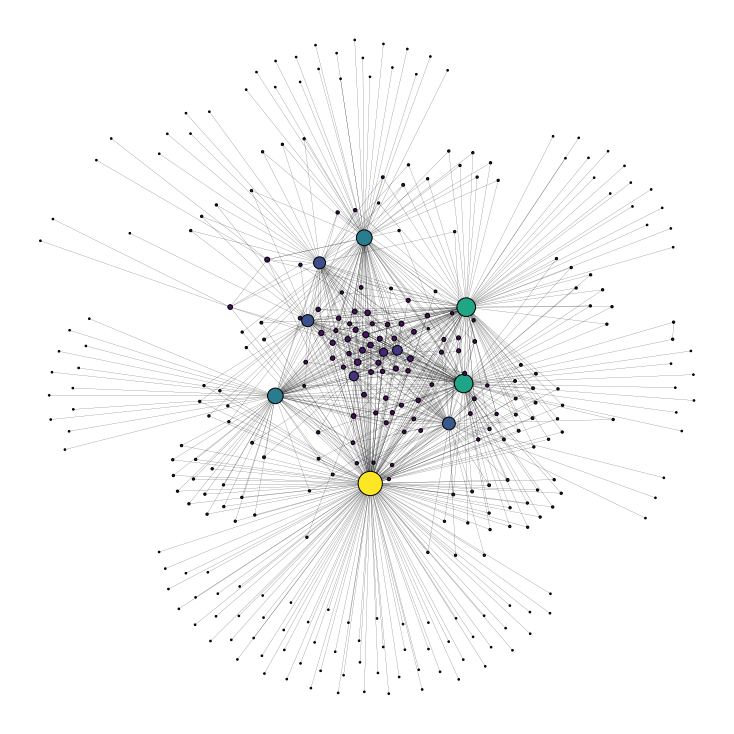

In [9]:
# color and size nodes based on centrality

# matplotlib - create a larger canvas
plt.rcParams['figure.figsize'] = (10,10)

# use a centrality measure...
dc = nx.degree_centrality(G)
#dc = nx.betweenness_centrality(G)
#dc = nx.closeness_centrality(G)
#dc = nx.eigenvector_centrality(G, max_iter=1000)

ds = np.array(list(dc.values()))

# scaling by the number of nodes in the graph to normalize 
df = G.size() * ds

# fix alpha
alpha = 1.0

# fix edge width
wd = 0.15

pos = nx.fruchterman_reingold_layout(G,iterations=400)

nx.draw(G, pos=pos, alpha=alpha, width=wd, cmap='viridis', node_size=df, node_color=df, edgecolors='black', linewidths=1)

plt.savefig('./results/airline-network-0.png')
plt.show()

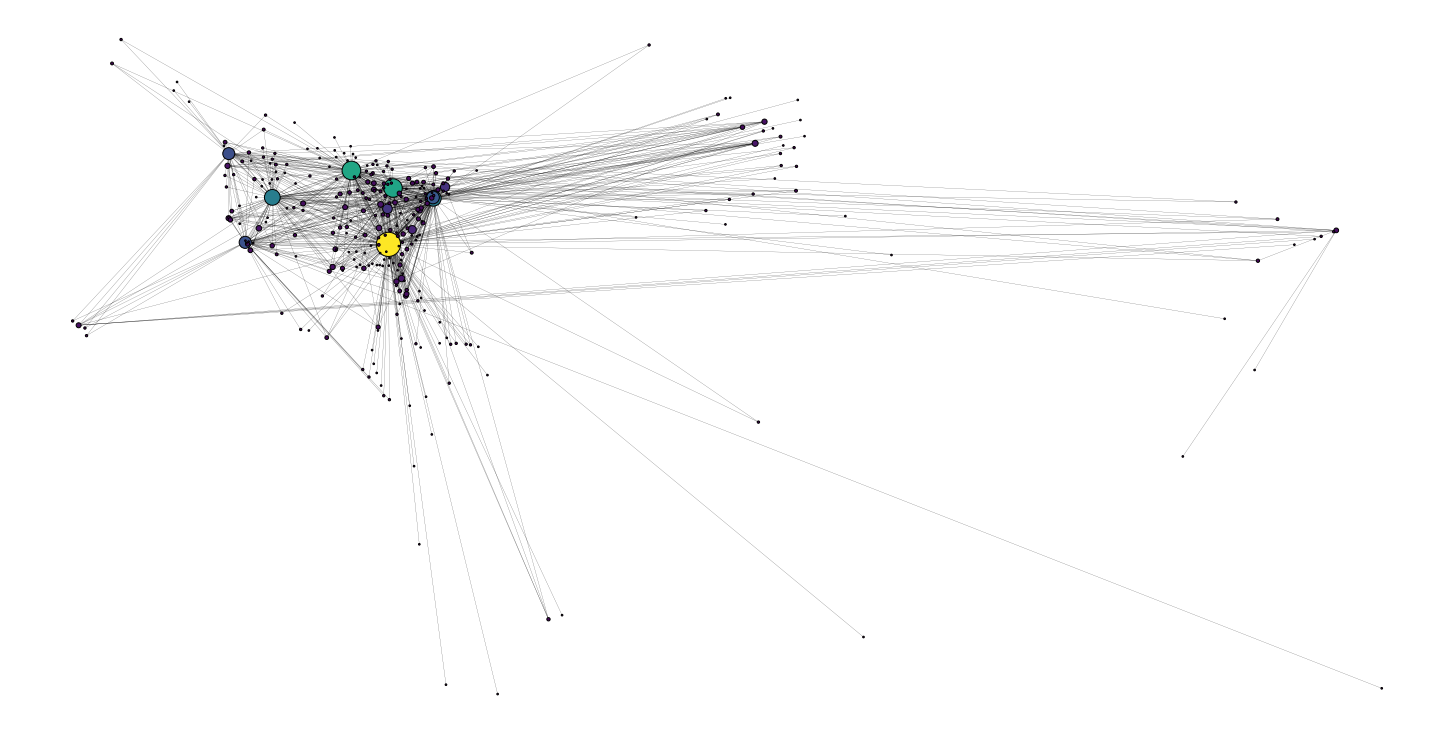

In [10]:
# display the graph using the latitude,longitude as the node positions

# matplotlib - create a larger canvas - note aspect ratio is important in this case otherwise the longitudes 
# will get rescaled
plt.rcParams['figure.figsize'] = (20,10)

# get the nodes (airports)
airports = [k for k in G.nodes]

# get the latitudes previsouly stored at attributes when we created the network
lats_attr = nx.get_node_attributes(G, 'Latitude')
lats = [lats_attr[k] for k in lats_attr]

# get the longitudes previously stored
longs_attr = nx.get_node_attributes(G, 'Longitude')
longs = [longs_attr[k] for k in longs_attr]

# build the new positions for drawing the network
latlng = list(zip(longs,lats))
latlng2 = [np.array(k) for k in latlng]
pos2 = dict(zip(airports, latlng2))

# draw the network
nx.draw(G, pos=pos2, alpha=alpha, width=wd, cmap='viridis', node_size=df, node_color=df, edgecolors='black', linewidths=1)

plt.savefig('./results/airline-network-1.png')

In [11]:
# Save the model for use in another program
results_file = 'results/airline.graphml'
nx.write_graphml(G, results_file)